<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/06_scaling_up_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Jun 19 08:25:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-19 08:25:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-19 08:25:27 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2022-06-19 08:25:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  82.9MB/s    in 21s     

2022-06-19 08:25:51 (72.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images 

In [ ]:
import tensorflow as tf

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=(224, 224)
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=(224, 224),
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"] 
)

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 110s 366ms/step - loss: 3.4698 - accuracy: 0.2490 - val_loss: 2.7163 - val_accuracy: 0.3840
Epoch 2/5
237/237 [==============================] - 69s 288ms/step - loss: 2.3499 - accuracy: 0.4603 - val_loss: 2.2227 - val_accuracy: 0.4658
Epoch 3/5
237/237 [==============================] - 63s 264ms/step - loss: 1.9764 - accuracy: 0.5281 - val_loss: 2.0885 - val_accuracy: 0.4783
Epoch 4/5
237/237 [==============================] - 63s 263ms/step - loss: 1.7662 - accuracy: 0.5677 - val_loss: 1.9672 - val_accuracy: 0.5079
Epoch 5/5
237/237 [==============================] - 51s 214ms/step - loss: 1.5995 - accuracy: 0.6069 - val_loss: 1.9299 - val_accuracy: 0.5064


In [ ]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7075 - accuracy: 0.5543


[1.7074840068817139, 0.5542970299720764]

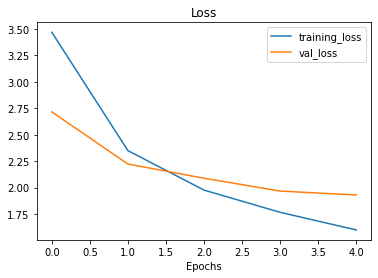

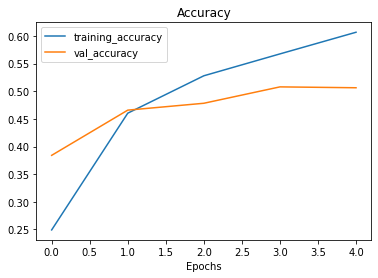

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

In [ ]:
history_fine_tuned = model.fit(
    train_data_all_10_percent,
    epochs=10,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 58s 213ms/step - loss: 1.3651 - accuracy: 0.6479 - val_loss: 1.8751 - val_accuracy: 0.5146
Epoch 6/10
237/237 [==============================] - 44s 184ms/step - loss: 1.2372 - accuracy: 0.6735 - val_loss: 1.8893 - val_accuracy: 0.5117
Epoch 7/10
237/237 [==============================] - 44s 185ms/step - loss: 1.1616 - accuracy: 0.6884 - val_loss: 1.8259 - val_accuracy: 0.5297
Epoch 8/10
237/237 [==============================] - 42s 177ms/step - loss: 1.0809 - accuracy: 0.7127 - val_loss: 1.8783 - val_accuracy: 0.5127
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.0306 - accuracy: 0.7282 - val_loss: 1.8764 - val_accuracy: 0.5177
Epoch 10/10
237/237 [==============================] - 38s 161ms/step - loss: 0.9711 - accuracy: 0.7370 - val_loss: 1.8428 - val_accuracy: 0.5252


In [ ]:
fine_tuned_results = model.evaluate(test_data)
fine_tuned_results

790/790 [==============================] - 58s 73ms/step - loss: 1.6008 - accuracy: 0.5794


[1.60077965259552, 0.5793663263320923]

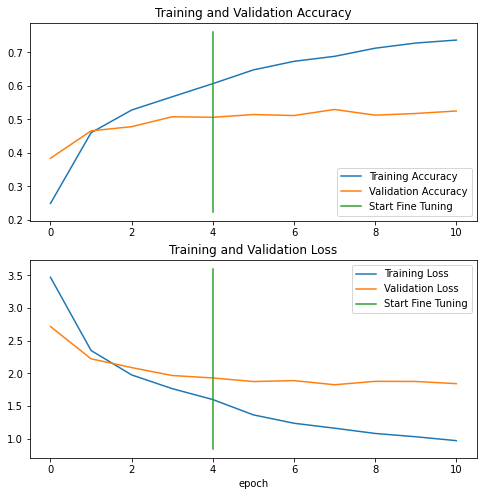

In [ ]:
compare_historys(history_all_classes_10_percent, history_fine_tuned)

In [ ]:
model.save("./saved_model")

INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model("./saved_model")

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 61s 75ms/step - loss: 1.6008 - accuracy: 0.5794


[1.60077965259552, 0.5793663263320923]

In [ ]:
fine_tuned_results

[1.60077965259552, 0.5793663263320923]

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-19 08:43:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  33.8MB/s    in 1.3s    

2022-06-19 08:43:37 (33.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
import numpy as np
np.isclose(model.evaluate(test_data), fine_tuned_results)

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


array([False, False])

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 62s 77ms/step


In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.95419519e-02, 3.57420822e-06, 4.13769744e-02, 1.06605547e-09,
        8.16142798e-09, 8.66396554e-09, 8.09271114e-07, 8.56526640e-07,
        1.98590151e-05, 8.09776168e-07, 3.17277427e-09, 9.86738314e-07,
        2.85322167e-04, 7.80493392e-10, 7.42300879e-04, 3.89163397e-05,
        6.47404340e-06, 2.49773279e-06, 3.78911318e-05, 2.06783056e-07,
        1.55384496e-05, 8.15069370e-07, 2.62305412e-06, 2.00106655e-07,
        8.38272967e-07, 5.42159842e-06, 3.73909279e-06, 1.31505820e-08,
        2.77614314e-03, 2.80519198e-05, 6.85624113e-10, 2.55748309e-05,
        1.66888960e-04, 7.64069974e-10, 4.04528371e-04, 1.31506335e-08,
        1.79573772e-06, 1.44482158e-06, 2.30628997e-02, 8.24667779e-07,
        8.53657696e-07, 1.71386114e-06, 7.05252342e-06, 1.84021669e-08,
        2.85532963e-07, 7.94833795e-06, 2.06815525e-06, 1.85251338e-07,
        3.36196422e-08, 3.15225538e-04, 1.04109122e-05, 8.54483574e-07,
        8.47418606e-01, 1.05554345e-05, 4.40945854e-07, 3.740414

In [ ]:
print(f"index of max probability: {tf.argmax(pred_probs[0])}")

index of max probability: 52


In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# unraveling test_data

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

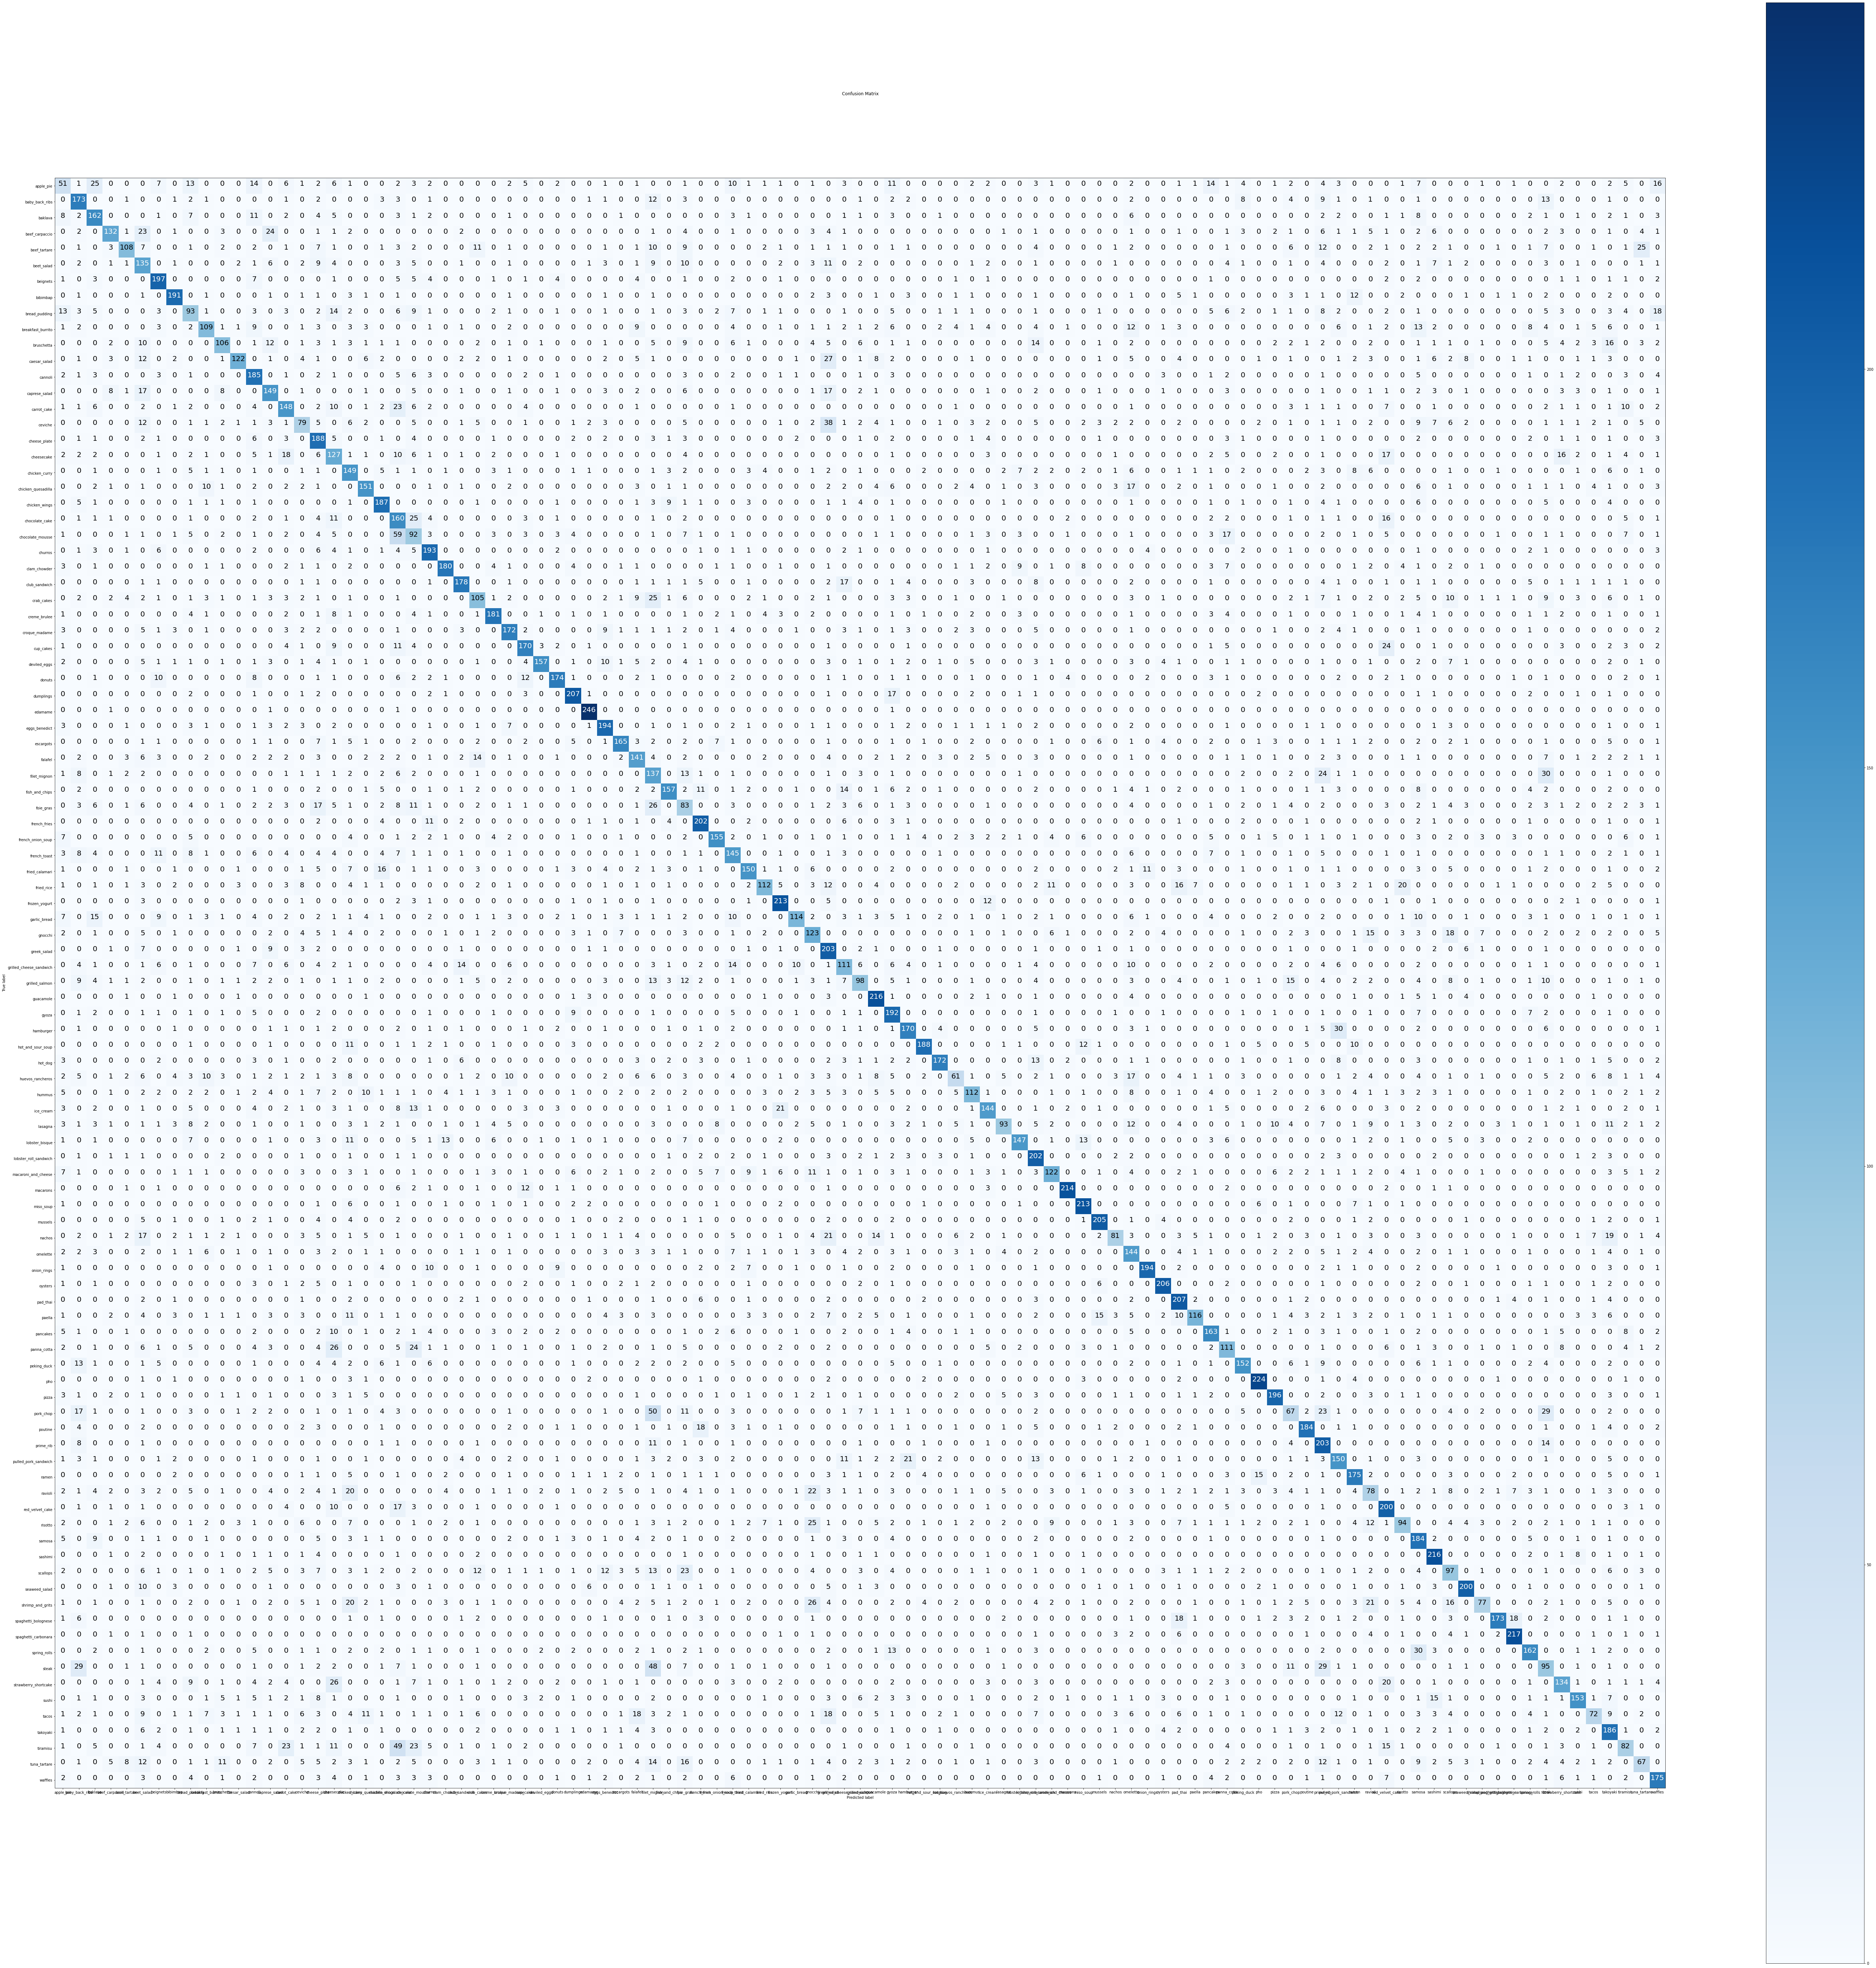

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_labels, pred_classes, test_data.class_names, (100, 100), 20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({
    "class_names": list(class_f1_scores.keys()),
    "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores[:10]

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


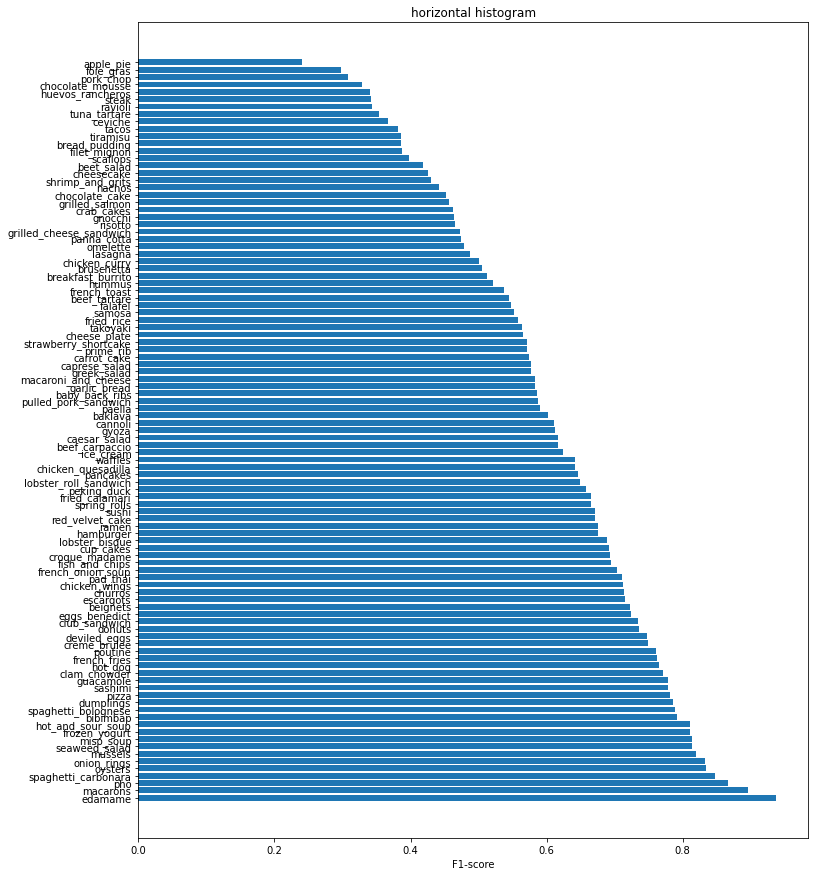

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 15))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("horizontal histogram")
ax.invert_yaxis;

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

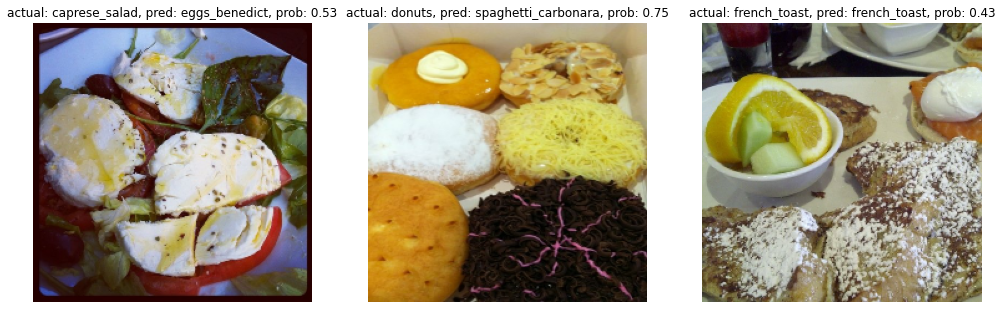

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()]

  #print(filepath)
  #print(pred_prob)
  #print(pred_class)

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);

In [ ]:
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle = False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
pred_df = pd.DataFrame({
    "img_path": filepaths,
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": pred_probs.max(axis=1),
    "y_true_classname": [test_data.class_names[i] for i in y_labels],
    "y_pred_classname": [test_data.class_names[i] for i in pred_classes],
})

pred_df["pred_correct"] = pred_df["y_true_classname"] == pred_df["y_pred_classname"]

pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib,False
...,...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles,True
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878027,waffles,cheese_plate,False
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537900,waffles,waffles,True
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501950,waffles,strawberry_shortcake,False


In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
8763,b'/content/101_food_classes_10_percent/test/es...,35,41,0.997169,escargots,french_onion_soup,False
2663,b'/content/101_food_classes_10_percent/test/br...,10,61,0.997055,bruschetta,lobster_roll_sandwich,False
7924,b'/content/101_food_classes_10_percent/test/do...,31,29,0.997020,donuts,cup_cakes,False
18586,b'/content/101_food_classes_10_percent/test/pe...,74,39,0.996885,peking_duck,foie_gras,False


In [68]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-06-19 10:44:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.2’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.09s   

2022-06-19 10:44:42 (147 MB/s) - ‘custom_food_images.zip.2’ saved [13192985/13192985]



In [70]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg']

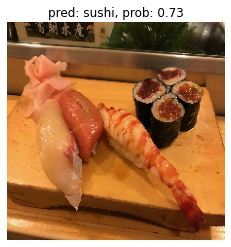

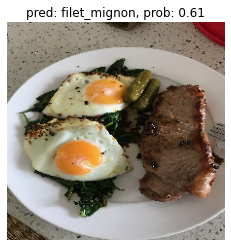

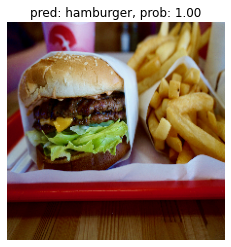

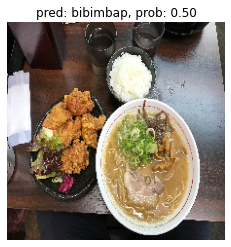

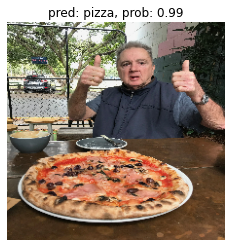

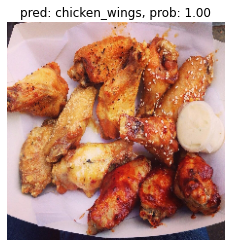

In [72]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);